In [46]:
%load_ext autoreload
%autoreload 2

import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MNIST from OpenML

In [48]:
X, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False, parser='auto')

In [49]:
y = y_mc.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=6)
num_classes = 10

# Train an XGBoost model

In [50]:
import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [51]:
params = {
    "n_estimators": 5, #50,
    "num_class": num_classes,
    "objective": "multi:softmax",
    "eval_metric": "merror",
    #"eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 7,
    "learning_rate": 0.2,
    "colsample_bynode": 0.75,
    "subsample": 0.5
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 9.852135181427002 seconds


In [52]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.944, test acc: 0.945 wrt true labels


# Convert multiclass XGB to multiclass addtree

In [53]:
feat2id = lambda f: int(f[1:])
ats = veritas.addtrees_from_multiclass_xgb_model(model, 10, feat2id) 

In [54]:
#10 addtrees, 1-vs-all for each class
print(len(ats), len(ats[0]))

10 5


In [55]:
# create one multiclass addtree by adding all trees one after the other
at = ats[0].make_multiclass(0, num_classes)
for k in range(1, num_classes):
    at.add_trees(ats[k], k)

print(len(at))

50


# Extract one base example

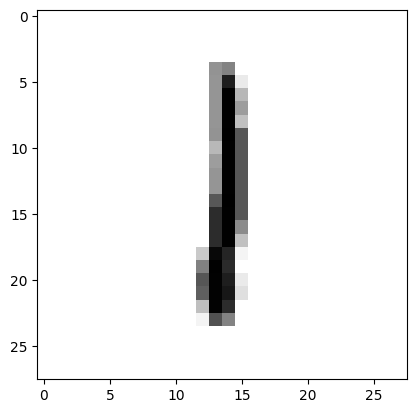

In [56]:
# select one example of class 1
number_of_adv_examples = 1

rng = np.random.default_rng(seed=6)
xtest0 = xtest[ytest_pred==1, :]
subset = xtest0[rng.choice(range(xtest0.shape[0]), number_of_adv_examples), :]

plt.imshow((subset[0,:]).reshape((28,28)), cmap="binary")

In [57]:
# test outputs for chosen base example
base_example = subset[0,:]
y_xgb = model.predict(subset)
y_ats = at.eval(subset)
y_xgb, y_ats

(array([1], dtype=int32),
 array([[-0.53833444,  2.05442472, -0.47533392, -0.51145764, -0.53236277,
         -0.50373326, -0.50889067, -0.51106049, -0.50994134, -0.48897046]]))

In [58]:
# Test on multiclass heuristics consistency: upper bound should never increase (it's an overestimate)

In [59]:
eps = 10
c = 2 #c vs 1
atc = at.copy()
atc.swap_class(c)

config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
#config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
#config.ignore_state_when_worse_than = 0.0
config.max_focal_size = 0
prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
s = config.get_search(atc, prune_box)

bounds = []

while True:
    stop_reason = s.steps(100)

    bound = s.current_bounds().top_of_open
    bounds.append(bound)
    
    if s.stats.num_steps==100000 or stop_reason==veritas.StopReason.NO_MORE_OPEN:
        print(stop_reason)
        break

atc.swap_class(c)

if s.num_solutions() > 0:
    sol = s.get_solution(0)
    adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

    print(at.eval(base_example)[0])
    print(at.eval(adv_example)[0])        

StopReason.NONE
[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.53833444 -0.53081766  2.27504837 -0.51354375 -0.53585395 -0.51508767
 -0.51800934 -0.5219137  -0.5149904  -0.527325  ]


1000


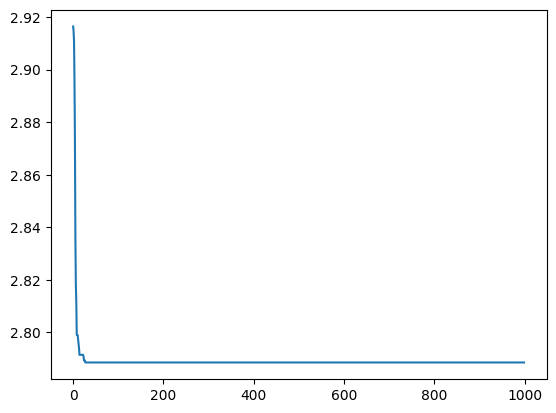

In [60]:
print(len(bounds))
plt.plot(range(len(bounds)), bounds)

In [61]:
# fine, bounds now decrease as the search goes on and acquires more info on the result overestimation made by the heuristic
# so let's now check if we get actual good results

# MAX_MAX example: targeted attack - one adv. ex. per class

In [62]:
### MAX_MAX multiclass

adv_examples = []
atc = at.copy()


# once per class (class0 --> class1, class0 --> class2, ...)
for c in range(0, num_classes):
    if c==1:
        continue
        
    print(c)
    atc.swap_class(c)

    config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc, prune_box)
    s.set_max_memory(16*1024*1024*1024)

    tstart = time.time()
    while s.num_solutions() == 0:
        stop_reason = s.steps(1000)
        #print(s.stats.num_steps, stop_reason)
        if stop_reason != veritas.StopReason.NONE:
            break
        
    tstop = time.time()

    atc.swap_class(c)

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        res = {"c": c, "adv_example": adv_example, "base_example": base_example}

        #res["base_ypred_at"] = at.eval(base_example)[0]
        #res["adv_ypred_at"] = at.eval(adv_example)[0]

        print(at.eval(base_example)[0])
        print(at.eval(adv_example)[0])
        print(sol.output)
        print()
        print()

        adv_examples.append(res)
        
    else:
        print("no adversarial examples found for", c)

    #break

0
[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.3894745  -0.5087923  -0.50747204 -0.51308484 -0.50747558 -0.50932729
 -0.50708447 -0.51233513 -0.51096543 -0.51351509]
0.11760996939999985


2
[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.53833444 -0.4187032   2.27504837 -0.47023252 -0.53258454 -0.50778998
 -0.45415369 -0.50916974 -0.44336571 -0.49770602]
2.6937515758999995


3
[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.53833444 -0.4187032  -0.43781676  0.82245937 -0.53236277 -0.50778998
 -0.49132675 -0.47375704 -0.50856046 -0.49745063]
1.2411625691


4
[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.53833444 -0.47515571 -0.47754696 -0.49574612 -0.14832737 -0.47499715


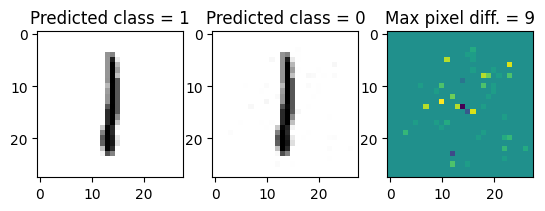

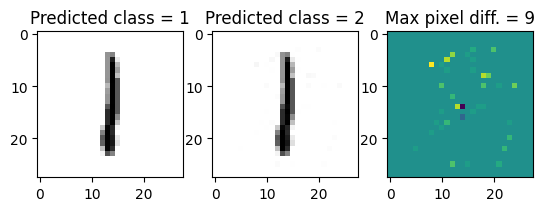

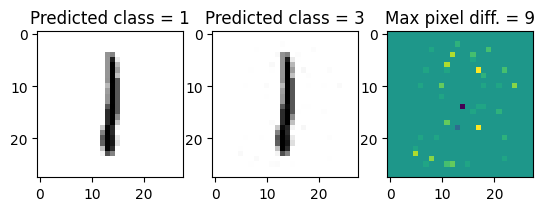

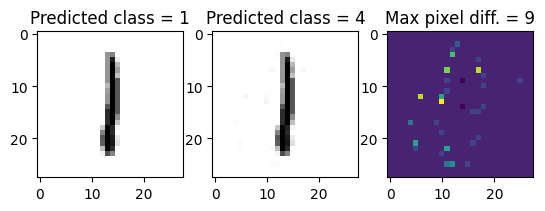

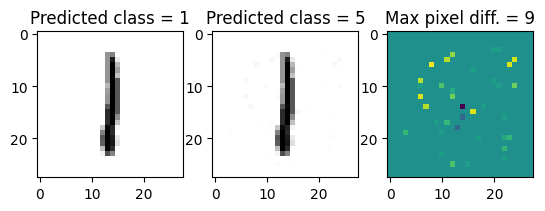

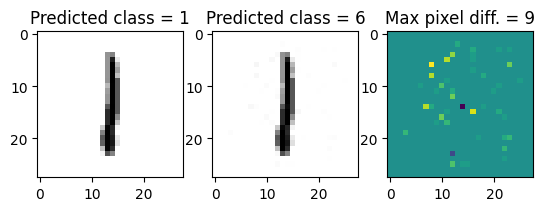

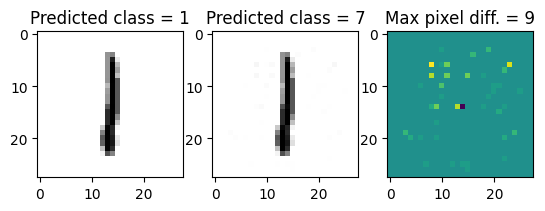

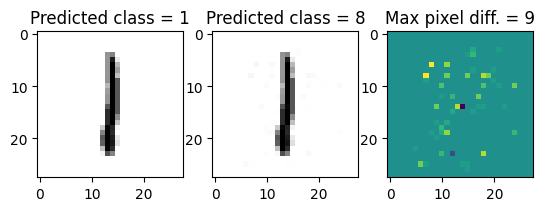

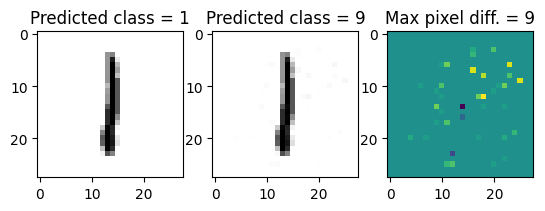

In [63]:
for i, res in enumerate(adv_examples):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((res["base_example"]).reshape((28,28)), cmap="binary")
    base_class = np.argmax(at.eval(res["base_example"])[0])
    ax[0].set_title(f"Predicted class = {base_class}")
    adv_class = np.argmax(at.eval(res["adv_example"])[0])
    ax[1].imshow((res["adv_example"]).reshape((28,28)), cmap="binary")
    ax[1].set_title(f"Predicted class = {adv_class}")
    ax[2].imshow((res["adv_example"]-res["base_example"]).reshape((28,28)))
    max_diff = np.max(np.abs(res["base_example"]-res["adv_example"]))
    ax[2].set_title(f"Max pixel diff. = {int(max_diff)}")

In [64]:
# smaller eps so that we sometime fail
eps = 5
adv_examples = []
atc = at.copy()

# once per class (class0 --> class1, class0 --> class2, ...)
for c in range(0, num_classes):
    if c==1:
        continue
        
    #print(c)
    atc.swap_class(c)

    config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc, prune_box)
    s.set_max_memory(16*1024*1024*1024)

    tstart = time.time()
    while s.num_solutions() == 0:
        stop_reason = s.steps(1000)
        #print(s.stats.num_steps, stop_reason)
        if stop_reason != veritas.StopReason.NONE:
            break
        
    tstop = time.time()

    atc.swap_class(c)

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)
        
        res = {"c": c, "adv_example": adv_example, "base_example": base_example}
        adv_examples.append(res)
        
    else:
        print("no adversarial examples found for class", c)

no adversarial examples found for class 4


In [65]:
# we did not find an adv. ex. for class 4
# what if we do binary classification 4vAll (trying to maximize for class 4)?

In [66]:
### MAX_OUTPUT binary

# only take trees for c vs 1
for c in range(0, num_classes):

    #if c==1:
    if c!=4:
        continue

    #print(c)
    
    at_ = ats[c].concat_negated(ats[1])

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(at_, prune_box)
    s.set_max_memory(16*1024*1024*1024)
    
    while s.num_solutions() == 0:
        if s.steps(100) != veritas.StopReason.NONE:
            break
    
    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        if c==4:
            print(at_.eval(base_example)[0])
            print(at_.eval(adv_example)[0], sol.output)
            print()
            print(at.eval(base_example)[0])
            print(at.eval(adv_example)[0], sol.output)
            print(np.argmax(at.eval(adv_example)[0]))
            print()
        """
        #debug stuff related to get_closest_example
        leaf_ids = [at_[i].eval_node(adv_example)[0] for i in range(len(at_))]
        leaf_vals = [at_[i].get_leaf_values(j)[0] for i, j in zip(range(len(at_)), leaf_ids)]

        leaf_ids2 = s.get_solution_nodes(0)  
        print(leaf_ids, leaf_ids2)
        print(np.array(leaf_ids)!=np.array(leaf_ids2))
        print(np.sum(np.array(leaf_ids)!=np.array(leaf_ids2)))
        #print(np.sum(leaf_vals), sol.output)

        #box = sol.box()
        #for f in box.keys():
        #    print(adv_example[f], box[f], box[f].contains(adv_example[f]))
        
        #print()

        break
        """
        
    else:
        print("no adversarial examples found")

[-2.58678748]
[0.00176947] 0.0017694670000000245

[-0.53833444  2.05442472 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046]
[-0.53833444 -0.53413223 -0.47533392 -0.51145764 -0.53236277 -0.50373326
 -0.50889067 -0.51106049 -0.50994134 -0.48897046] 0.0017694670000000245
2



In [67]:
# We find a result, BUT inspecting the evaluation on the full addTree we see that such result would not be classified as Class 4 in a multiclass setting - it would be a 2! 
# The two problems are slightly different.

In [68]:
### ISSUE: now xgboost multiclass model uses 5 trees per class --> small ensemble! For bigger values, heuristic still too slow.

In [69]:
#test: how many features are used in the at?
len(at.get_splits().keys())/(28*28)

0.6594387755102041